In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time

from src.python.methods import graphical_rica_2
from src.python.methods import cross_moment, cross_moment_sensor_fusion, tyc20
from src.python.generate_data import generate_data, generate_data_misspecification
from src.python.utils import save_torch_data

In [3]:
from random import choice

def hid_var_dag(latent=2,
                observed=5,
                dag_type = 'default',
                parents_max = 3,
                expected_degree=3):

    """
        Generate random Directed Acyclic Graphs (DAGs) with hidden variables.

        Parameters:
        - latent (int): Number of hidden variables.
        - observed (int): Number of observed variables.
        - dag_type (str): Type of DAG to generate ('default' or 'erdos').
        - parents_max (int): Maximum number of parents for observed variables in the 'default' DAG type.
        - expected_degree (int): Expected degree of nodes in the 'erdos' DAG type.

        Returns:
        - g (nx.DiGraph): Generated DAG as a NetworkX DiGraph object.

    """

    adj = np.zeros((latent+observed, latent+observed))
    for i in range(latent):
        obs_ch = np.random.randint(latent,latent+observed,np.random.randint(2,observed+1))
        for j in obs_ch:
            adj[i,j] = 1

    if dag_type == 'default':
        for j in range(1, observed):
            nb_parents = np.random.randint(0, min([parents_max, j])+1)
            for i in np.random.choice(range(0, j), nb_parents, replace=False):
                adj[latent+i,latent+j] = 1

    elif dag_type == 'erdos':
        nb_edges = expected_degree * observed
        prob_connection = 2 * nb_edges/(observed**2 - observed)
        causal_order = np.random.permutation(np.arange(observed))

        for i in range(observed - 1):
            node = causal_order[i]
            possible_parents = causal_order[(i+1):]
            num_parents = np.random.binomial(n=observed - i - 1,
                                             p=prob_connection)
            parents = np.random.choice(possible_parents, size=num_parents,
                                       replace=False)
            adj[latent+parents,latent+node] = 1

    graph = nx.DiGraph(adj)
    return graph





"GENERATE PARAMETERS"
def par_gen(latent=2,
            observed=5,
            graph = None,
            graph_adj = None,
            same_var = True,
            v_min = 0.2,
            v_max = 10,
            stn_ratio = 1,
            w_max = 10):

    varr = par_gen_var(latent=latent,
                       observed=observed,
                       graph =  graph,
                       graph_adj =  graph_adj,
                       same_var = same_var,
                       v_min = v_min,
                       v_max = v_max,
                       stn_ratio = stn_ratio)

    weight, B = par_gen_weights(graph =  graph,
                                w_max = w_max)

    return varr, weight, B

def par_gen_var(latent=2,
                observed=5,
                graph = None,
                graph_adj = None,
                same_var = True,
                v_min = 0.2,
                v_max = 10,
                stn_ratio = 1):

    varr = torch.Tensor(len(graph.nodes()))
    if same_var == 'True':
        varr[range(latent)] = torch.ones(observed)
        varr[range(latent,latent+observed)] = torch.ones(observed)

    else:
        varr[range(latent)] = torch.Tensor(latent).uniform_(v_min,v_max)
        varr[range(latent, latent+observed)] = torch.Tensor(observed).uniform_(v_min,v_max)
    
    if stn_ratio > 0:
        for i in range(latent):
            j = latent
            find_first_ch = False
            while(j < latent + observed and find_first_ch is False):
                if (graph_adj[i, j] == 1):
                    find_first_ch = True
                j += 1
            if find_first_ch is False:
                varr[i] = torch.Tensor(1).uniform_(v_min,v_max)
            else:
                varr[i] = varr[j]*stn_ratio

    return varr

def par_gen_weights(graph = None,
                    w_max = 10,
                    no_small = True
                    ):
    
    if no_small is True:
        weight = torch.Tensor(len(graph.edges())).uniform_(0.2,w_max) 
        weight = weight * torch.Tensor([choice([-1, 1]) for i in range(len(graph.edges()))])
    else: 
        weight = torch.Tensor(len(graph.edges())).uniform_(-w_max,w_max)

    adj = torch.eye(len(graph.nodes()))
    for e in range(len(graph.edges())):
        adj[list(graph.edges)[e]]=-weight[e]
    B = (torch.inverse(adj)).t()

    return weight, B




def hid_var_data(latent=2,
                 observed=5,
                 n = 500,
                 B = None,
                 distr = 'Laplace',
                 varr = torch.ones(7)
                 ):
    """
    Generate, possibly whitened, data from a given DAG.

    Parameters:
        - latent (int): Number of hidden variables.
        - observed (int): Number of observed variables.
        - g (nx.DiGraph): The DAG as a NetworkX DiGraph object.
        - n (int): Number of data samples to generate.
        - withening (bool): Flag to apply whitening to the data.
        - distr(string): 'Laplace' or 'Cauchy'
        - same_var(bool): True if the noise terms must have the same variance

    Returns:
        - data (torch.Tensor): Generated data.
        - adj (torch.Tensor): Adjacency matrix of the DAG.
        - W_with (torch.Tensor): Whitening matrix (if applicable otherwise identity matrix).
        - weight (torch.Tensor): Weights associated with the DAG edges.

    """

    err = torch.Tensor(latent+observed,n)

    for j in range(latent+observed):
        for i in range(n):
            if distr == 'Laplace':
                err[j,i] = torch.distributions.laplace.Laplace(0,1).sample()*varr[j]
            elif distr == 'Cauchy':
                err[j, i] = torch.Tensor(1).cauchy_()*varr[j]
            elif distr == 'Normal':
                err[j, i] = torch.Tensor(1).normal_()*varr[j]
            else:
                print(distr , 'error')
                break



    #err = torch.Tensor(latent+observed,n).cauchy_()
    data = B.matmul(err).t()
    data = data[:,range(latent, observed+latent)]

    return data


In [4]:
def hid_var_dag(latent=2,
                observed=5,
                prob_acc=0.5):
    """
        - Generates a random DAG with hidden variables.
        - Parameters:
             - latent (int): Number of hidden variables.
             - observed (int): Number of observed variables.
             - prob_acc (float): Probability of accepting an edge.
        - Returns:
             - g (nx.DiGraph): Generated DAG as a NetworkX DiGraph object.
    """

    adj = np.zeros((latent+observed, latent+observed))
    for i in range(latent+observed):
        for j in range(max(i+1, latent), latent+observed):
            if np.random.uniform(0, 1) < prob_acc:
                adj[i, j] = 1

    return nx.DiGraph(adj), adj

def full_graph_id(graph=None,
                  latent=0):
    """
        - Checks identifiability of all the parameters in the graph.
        - Parameters:
             - graph (networkx.DiGraph): Graph to analyze.
             - latent (int): Number of latent variables.
        - Returns:
             - Tuple of booleans (id_known, id_unknown) indicating global identifiability status.
    """

    start_time = time.time()
    id_known = True
    id_unknown = True
    k = 0
    while id_known is True and k < latent:
        ch_k = sorted(graph.successors(k))

        if len(ch_k) > 1:
            j_k = ch_k[0]
            de_k = sorted(nx.descendants(graph, k))
            de_j = sorted(nx.descendants(graph, j_k) | {j_k})

            if de_j == de_k:
                id_unknown = False
                id_known = False

                g_copy = graph.copy()
                pa_j = sorted(graph.predecessors(j_k))

                for par in pa_j:
                    g_copy.remove_edge(par, j_k)

                ch_k_not_j = sorted(g_copy.successors(k))

                for i in pa_j + [j_k]:
                    ch_i = sorted(g_copy.successors(i))

                    if sum(f in ch_i for f in ch_k_not_j) < len(ch_k_not_j):
                        id_known = True
        k += 1

    end_time = time.time()
    tot_time = end_time-start_time

    return id_known, id_unknown, tot_time

In [5]:
def make_table(results):

    p_latents = np.unique(results['p_latent'])
    p_observeds = np.unique(results['p_observed'])
    for p_latent in p_latents:
        for p_observed in p_observeds:
            data_p = results.loc[(results['p_latent'] == p_latent) & 
                                 (results['p_observed'] == p_observed) &
                                 (results['graph_id'] == True)]
            data_p_group = data_p.groupby(['sample_size', 'method'])
            
            mean_data = data_p_group[['loss']].median()
            print(f'p_latents = {p_latent}, p_observed = {p_observed}')
            print(mean_data)

In [6]:
RUN_MATLAB = True

## Random Graphs

## Relative error vs sample size

#### Latent: 2 & Observed: 10

In [7]:
distr_name = "Laplace"
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 2000

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [15, 30, 50, 100,1000,10000]
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

distr_params = None

In [8]:
p_latents = [1]
p_observeds = [5]
n_trials = 10
columns = [
        'p_latent',
        'p_observed',
        'method',
        'loss',
        ]
loss_res = pd.DataFrame(columns=columns)
temp_results = []
w_max = 2
for i, p_latent in enumerate(p_latents):
    for j, p_observed in enumerate(p_observeds):    
        for trial in range(n_trials):
                    
            graph_id = False
            graphs_count = 0
            while(graph_id is False and graphs_count<100):
                graph, graph_adj = hid_var_dag(latent = p_latent,observed = p_observed,prob_acc=0.5)
                graph_adj_obs = graph_adj[p_latent:,p_latent:]
                if sum(sum(graph_adj_obs)) > p_observed:
                    graph_id, _, _ = full_graph_id(graph = graph,latent = p_latent)
                    for latent_i in range(p_latent):
                        if sum(graph_adj[latent_i,:]) == 0:
                            graph_id = False

                weight_true, b_true = par_gen_weights(graph = graph,
                                                      w_max = w_max)
                graphs_count += 1
            b_true_obs = b_true[p_latent:,p_latent:] 

            observed = p_observed
            latent = p_latent
            data_stored, adj, weights = generate_data(graph, observed, latent, weight_true, mode, max_samples, distr_name, distr_params_default, distr_params)
            
            if RUN_MATLAB:
                filename = "./data/data_stored.csv"
                save_torch_data(data_stored, filename)
                !matlab -batch "q=6;run('./src/matlab/main_random_graph.m');"
            

            for k, n_samples in enumerate(samples_list):
                if RUN_MATLAB:
                    # RICA
                    b_rica = np.genfromtxt(f"./data/prediction/B_{k+1}.txt", delimiter=',')
                    rica_loss = ((b_true_obs - b_rica[:, p_latent:]).square().mean()/b_true_obs.square().mean()).item()

                    iteration_results = {
                        'p_latent': p_latent, 
                        'p_observed': p_observed,
                        'method': 'RICA',
                        'sample_size': n_samples,
                        'loss': rica_loss,
                        'graph_id': graph_id,
                    }
                
                    temp_results.append(iteration_results.copy())
            
                #GRICA
                data = data_stored[:n_samples]
                
                loss_data, w_data = graphical_rica_2(withening = True,
                                                pseudoinv = False,
                                                latent = p_latent,
                                                observed = p_observed,
                                                graph = graph,
                                                data = data,
                                                mom = 0,
                                                lambda_reg = 0,
                                                epochs = epochs,
                                                lr = 0.1,
                                                w_true = weight_true,
                                                w_init = 'cov_guess',
                                                use_scheduler = False)

                loss_at_min= loss_data.min(0)[0].item()
                loss_at_min_loc = loss_data.min(0)[1].item()   
                
                adj = torch.eye(len(graph.nodes()))
                for e in range(len(graph.edges())):
                    adj[list(graph.edges)[e]]=-w_data[e, loss_at_min_loc]
                b_est = (torch.inverse(adj)).t()
                    

                b_est_obs = b_est[p_latent:, p_latent:]                
                b_loss_min = ((b_true_obs - b_est_obs).square().mean()/b_true_obs.square().mean()).item()

                adj = torch.eye(len(graph.nodes()))
                for e in range(len(graph.edges())):
                    adj[list(graph.edges)[e]]=-w_data[e, 0]
                b_est = (torch.inverse(adj)).t()
                    

                b_est_obs = b_est[p_latent:, p_latent:]                
                b_loss_beg = ((b_true_obs - b_est_obs).square().mean()/b_true_obs.square().mean()).item()
                # print(trial, n_samples, b_loss_beg, b_loss_min)               
                iteration_results = {
                    'p_latent': p_latent, 
                    'p_observed': p_observed,
                    'method': 'GRICA',
                    'sample_size': n_samples,
                    'loss': b_loss_min,
                    'graph_id': graph_id,
                }
            
                temp_results.append(iteration_results.copy())
                
results = pd.DataFrame(temp_results)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [9]:
make_table(results)

p_latents = 1, p_observed = 5
                        loss
sample_size method          
15          GRICA   0.112749
            RICA    1.646055
30          GRICA   0.108528
            RICA    1.515649
50          GRICA   0.093954
            RICA    1.455835
100         GRICA   0.100515
            RICA    1.465806
1000        GRICA   0.068767
            RICA    1.357498
10000       GRICA   0.071244
            RICA    1.428671


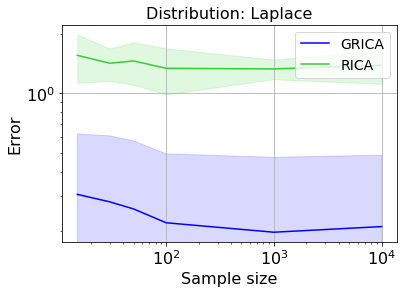

In [53]:
p_latents = np.unique(results['p_latent'])
p_observeds = np.unique(results['p_observed'])
for p_latent in p_latents:
    for p_observed in p_observeds:
        data_p = results.loc[(results['p_latent'] == p_latent) & 
                                (results['p_observed'] == p_observed) &
                                (results['graph_id'] == True)]
        data_p_group = data_p.groupby(['sample_size', 'method'])
        std_data = data_p_group[['loss']].std()
        mean_data = data_p_group[['loss']].mean()
x = samples_list
y_GRICA = []
y_GRICA_err = []
y_RICA = []
y_RICA_err = []
for i in range(len(samples_list)):
    y_GRICA.append(mean_data.iloc[i*2].item())
    y_RICA.append(mean_data.iloc[i*2+1].item())
    y_GRICA_err.append(std_data.iloc[i*2].item())
    y_RICA_err.append(std_data.iloc[i*2+1].item())

y_GRICA = np.array(y_GRICA)
y_GRICA_err = np.array(y_GRICA_err)
y_RICA = np.array(y_RICA)
y_RICA_err = np.array(y_RICA_err)
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.loglog(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - y_GRICA_err, y_GRICA + y_GRICA_err, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.loglog(x, y_RICA, label="RICA", color="limegreen")
    plt.fill_between(x, y_RICA - y_RICA_err, y_RICA + y_RICA_err, alpha=0.15, color="limegreen")

plt.legend(loc="upper right")
plt.grid()
# plt.ylim(0, 1)
plt.savefig(f"../Figures/Estimation/{distr_name}_random_graphs_samples_vs_err.png", bbox_inches="tight")
plt.show()

#### Latent: 2 & Observed: 10

In [54]:
distr_name = "Laplace"
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 2000

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [15, 30, 50, 100,1000,10000]
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

distr_params = None

In [55]:
# p_latents = [1, 2, 3]
# p_observeds = [10, 15]
p_latents = [2]
p_observeds = [10]
n_trials = 10
columns = [
        'p_latent',
        'p_observed',
        'method',
        'loss',
        ]
loss_res = pd.DataFrame(columns=columns)
temp_results = []
w_max = 2
for i, p_latent in enumerate(p_latents):
    for j, p_observed in enumerate(p_observeds):    
        for trial in range(n_trials):
                    
            graph_id = False
            graphs_count = 0
            while(graph_id is False and graphs_count<100):
                graph, graph_adj = hid_var_dag(latent = p_latent,observed = p_observed,prob_acc=0.5)
                graph_adj_obs = graph_adj[p_latent:,p_latent:]
                if sum(sum(graph_adj_obs)) > p_observed:
                    graph_id, _, _ = full_graph_id(graph = graph,latent = p_latent)
                    for latent_i in range(p_latent):
                        if sum(graph_adj[latent_i,:]) == 0:
                            graph_id = False

                weight_true, b_true = par_gen_weights(graph = graph,
                                                      w_max = w_max)
                graphs_count += 1
            b_true_obs = b_true[p_latent:,p_latent:] 

            observed = p_observed
            latent = p_latent
            data_stored, adj, weights = generate_data(graph, observed, latent, weight_true, mode, max_samples, distr_name, distr_params_default, distr_params)
            
            if RUN_MATLAB:
                filename = "./data/data_stored.csv"
                save_torch_data(data_stored, filename)
                !matlab -batch "q=12;run('./src/matlab/main_random_graph.m');"
            

            for k, n_samples in enumerate(samples_list):
                if RUN_MATLAB:
                    # RICA
                    b_rica = np.genfromtxt(f"./data/prediction/B_{k+1}.txt", delimiter=',')
                    rica_loss = ((b_true_obs - b_rica[:, p_latent:]).square().mean()/b_true_obs.square().mean()).item()

                    iteration_results = {
                        'p_latent': p_latent, 
                        'p_observed': p_observed,
                        'method': 'RICA',
                        'sample_size': n_samples,
                        'loss': rica_loss,
                        'graph_id': graph_id,
                    }
                
                    temp_results.append(iteration_results.copy())
            
                #GRICA
                data = data_stored[:n_samples]
                
                loss_data, w_data = graphical_rica_2(withening = True,
                                                pseudoinv = False,
                                                latent = p_latent,
                                                observed = p_observed,
                                                graph = graph,
                                                data = data,
                                                mom = 0,
                                                lambda_reg = 0,
                                                epochs = epochs,
                                                lr = 0.1,
                                                w_true = weight_true,
                                                w_init = 'cov_guess',
                                                use_scheduler = False)

                loss_at_min= loss_data.min(0)[0].item()
                loss_at_min_loc = loss_data.min(0)[1].item()   
                
                adj = torch.eye(len(graph.nodes()))
                for e in range(len(graph.edges())):
                    adj[list(graph.edges)[e]]=-w_data[e, loss_at_min_loc]
                b_est = (torch.inverse(adj)).t()
                    

                b_est_obs = b_est[p_latent:, p_latent:]                
                b_loss_min = ((b_true_obs - b_est_obs).square().mean()/b_true_obs.square().mean()).item()

                adj = torch.eye(len(graph.nodes()))
                for e in range(len(graph.edges())):
                    adj[list(graph.edges)[e]]=-w_data[e, 0]
                b_est = (torch.inverse(adj)).t()
                    

                b_est_obs = b_est[p_latent:, p_latent:]                
                b_loss_beg = ((b_true_obs - b_est_obs).square().mean()/b_true_obs.square().mean()).item()
                # print(trial, n_samples, b_loss_beg, b_loss_min)               
                iteration_results = {
                    'p_latent': p_latent, 
                    'p_observed': p_observed,
                    'method': 'GRICA',
                    'sample_size': n_samples,
                    'loss': b_loss_min,
                    'graph_id': graph_id,
                }
            
                temp_results.append(iteration_results.copy())
                
results = pd.DataFrame(temp_results)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
> In classreg.learning.fsutils/Solver/doMinimizationLBFGS (line 351)
In classreg.learning.fsutils/Solver/doMinimization (line 222)
In indexing (line 22)
In featlearn.utils.Solver.doMinimization (line 55)
In featlearn.impl/ReconstructionICAImpl/doRICA (line 124)
In featlearn.impl.ReconstructionICAImpl (line 47)
In ReconstructionICA (line 233)
In rica (line 68)
In estimate_model (line 12)
In rica_bootstrap (line 2)
In main_random_graph (line 15)
In run (line 99) 
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [56]:
make_table(results)

p_latents = 2, p_observed = 10
                        loss
sample_size method          
15          GRICA   0.435847
            RICA    1.188643
30          GRICA   0.169114
            RICA    1.175370
50          GRICA   0.137884
            RICA    1.182350
100         GRICA   0.096769
            RICA    1.227091
1000        GRICA   0.035260
            RICA    1.151908
10000       GRICA   0.043896
            RICA    1.186760


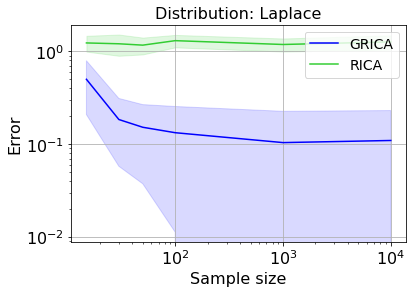

In [57]:
p_latents = np.unique(results['p_latent'])
p_observeds = np.unique(results['p_observed'])
for p_latent in p_latents:
    for p_observed in p_observeds:
        data_p = results.loc[(results['p_latent'] == p_latent) & 
                                (results['p_observed'] == p_observed) &
                                (results['graph_id'] == True)]
        data_p_group = data_p.groupby(['sample_size', 'method'])
        std_data = data_p_group[['loss']].std()
        mean_data = data_p_group[['loss']].mean()
x = samples_list
y_GRICA = []
y_GRICA_err = []
y_RICA = []
y_RICA_err = []
for i in range(len(samples_list)):
    y_GRICA.append(mean_data.iloc[i*2].item())
    y_RICA.append(mean_data.iloc[i*2+1].item())
    y_GRICA_err.append(std_data.iloc[i*2].item())
    y_RICA_err.append(std_data.iloc[i*2+1].item())

y_GRICA = np.array(y_GRICA)
y_GRICA_err = np.array(y_GRICA_err)
y_RICA = np.array(y_RICA)
y_RICA_err = np.array(y_RICA_err)
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.loglog(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - y_GRICA_err, y_GRICA + y_GRICA_err, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.loglog(x, y_RICA, label="RICA", color="limegreen")
    plt.fill_between(x, y_RICA - y_RICA_err, y_RICA + y_RICA_err, alpha=0.15, color="limegreen")

plt.legend(loc="upper right")
plt.grid()
# plt.ylim(0, 1)
plt.savefig(f"../Figures/Estimation/{distr_name}_random_graphs_samples_vs_err.png", bbox_inches="tight")
plt.show()